In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
import xgboost as xgb
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')
sbn.set(style='white')

In [81]:
train_data = pd.read_csv('../input/train.csv')
train_data.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074


In [84]:
test_data = pd.read_csv('../input/test.csv')
test_data.head()

,id,molecule_name,atom_index_0,atom_index_1,type
0,4658147,dsgdb9nsd_000004,2,0,2JHC
1,4658148,dsgdb9nsd_000004,2,1,1JHC
2,4658149,dsgdb9nsd_000004,2,3,3JHH
3,4658150,dsgdb9nsd_000004,3,0,1JHC
4,4658151,dsgdb9nsd_000004,3,1,2JHC


In [62]:
structure_data = pd.read_csv('../input/structures.csv')
structure_data.head()

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397


In [63]:
print("Missing values in training file:\n ", train_data.isnull().sum())
print("Missing values in Structures file:\n ", structure_data.isnull().sum())

Missing values in training file:
  id                          0
molecule_name               0
atom_index_0                0
atom_index_1                0
type                        0
scalar_coupling_constant    0
dtype: int64
Missing values in Structures file:
  molecule_name    0
atom_index       0
atom             0
x                0
y                0
z                0
dtype: int64


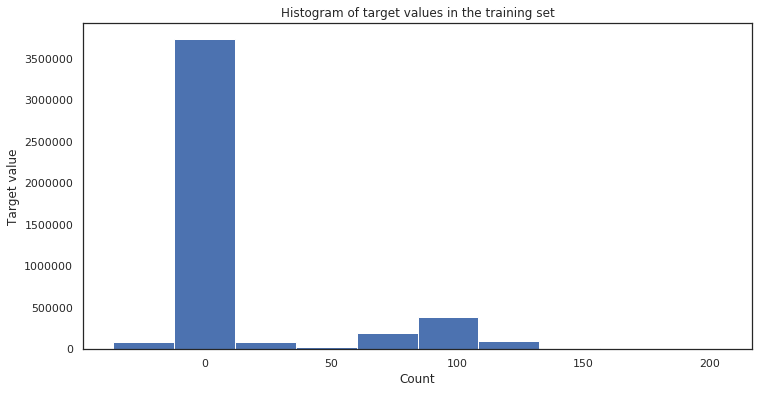

<Figure size 432x288 with 0 Axes>

In [64]:
plt.figure(figsize = (12, 6))
plt.hist(train_data['scalar_coupling_constant'])
plt.title('Histogram of target values in the training set')
plt.xlabel('Count')
plt.ylabel('Target value')
plt.show()
plt.clf()

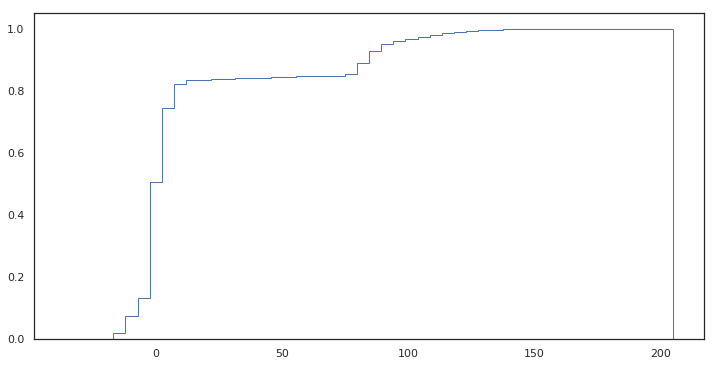

In [65]:
x = train_data['scalar_coupling_constant']

fig, ax = plt.subplots(figsize=(12, 6))
n_bins = 50

# plot the cumulative histogram
n, bins, patches = ax.hist(x, n_bins, normed=1, histtype='step',
                           cumulative=True, label='Empirical')

In [66]:
indices = [index for index, row in train_data.iterrows() 
           if row['scalar_coupling_constant']>160]
print("Before deletion: ", train_data.shape)
train_data.drop(train_data.index[indices], axis=0, inplace=True)
print("After deletion: ", train_data.shape)

Before deletion:  (4658147, 6)
After deletion:  (4648878, 6)


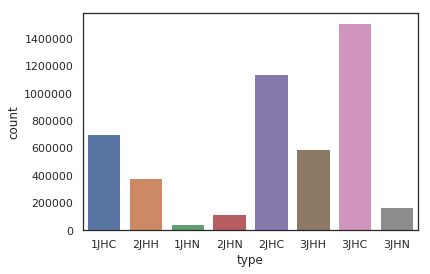

In [67]:
sbn.countplot(x='type', data=train_data)

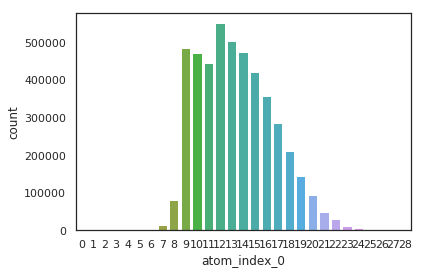

In [68]:
sbn.countplot(x='atom_index_0', data=train_data)

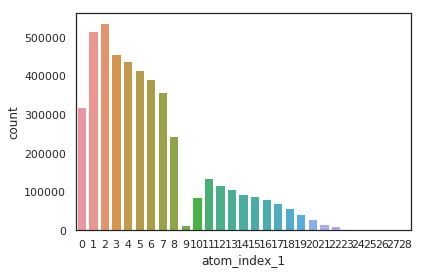

In [69]:
sbn.countplot(x='atom_index_1', data=train_data)

In [70]:
cross_index = ['atom_index_0','atom_index_1']

cm = sbn.light_palette("green", as_cmap=True)
pd.crosstab(train_data[cross_index[0]], train_data[cross_index[1]]).style.background_gradient(cmap = cm)

atom_index_1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
atom_index_0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,37,0,38,37,33,24,1,8,8,5,4,1,21,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,86,49,0,86,82,64,12,18,13,16,29,42,61,40,26,16,5,5,0,0,0,0,0,0,0,0,0,0,0
3,127,104,77,0,129,128,33,21,14,17,4,24,55,37,30,19,7,3,0,0,0,0,0,0,0,0,0,0,0
4,78,113,108,42,0,112,65,31,11,11,1,3,4,7,17,17,11,3,0,0,0,0,0,0,0,0,0,0,0
5,97,150,146,103,56,0,156,116,50,23,10,8,8,9,13,15,11,5,2,1,0,0,0,0,0,0,0,0,0
6,346,442,422,217,175,140,0,446,331,142,57,17,16,16,16,17,4,4,4,2,1,1,0,0,0,0,0,0,0
7,1804,2311,2200,852,594,599,587,0,2195,1686,752,270,43,43,39,20,19,5,8,4,3,2,0,0,0,0,0,0,0
8,10279,12973,12330,4554,2855,2762,2920,2583,0,12493,9702,4373,1570,161,144,116,82,68,22,31,5,5,0,0,0,0,0,0,0


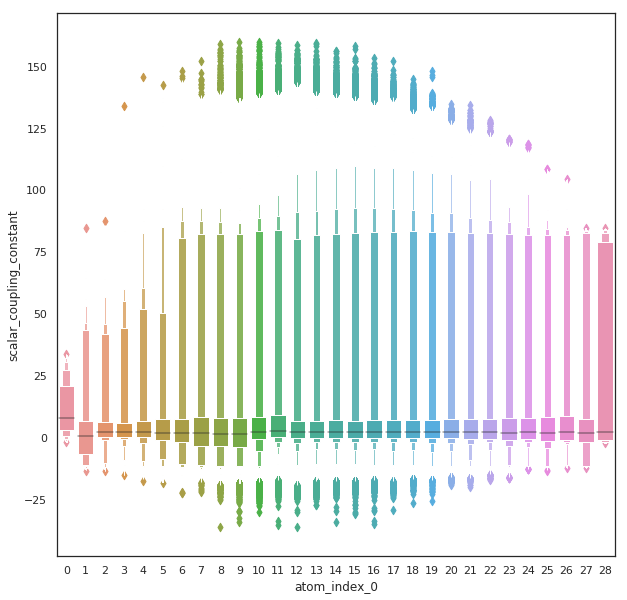

In [71]:
plt.figure(figsize=(10,10))
sbn.boxenplot(x='atom_index_0', y='scalar_coupling_constant', data=train_data)
plt.show()

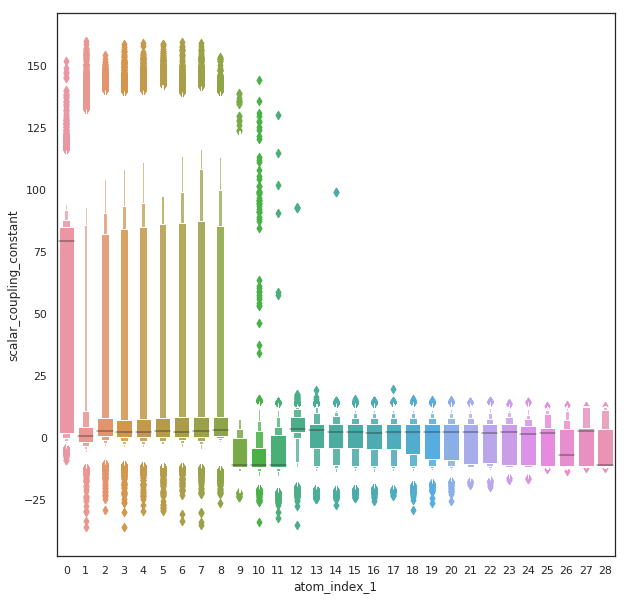

In [72]:
plt.figure(figsize=(10,10))
sbn.boxenplot(x='atom_index_1', y='scalar_coupling_constant', data=train_data)
plt.show()

In [73]:
scalar_index_cross = ['atom_index_0', 'atom_index_1']

cm = sbn.light_palette("green", as_cmap=True)
pd.crosstab(train_data[scalar_index_cross[0]], train_data[scalar_index_cross[1]], 
            values=train_data['scalar_coupling_constant'], aggfunc=['mean']).style.background_gradient(cmap = cm)

In [85]:
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structure_data, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

train_data = map_atom_info(train_data, 0)
train_data = map_atom_info(train_data, 1)

test_data = map_atom_info(test_data, 0)
test_data = map_atom_info(test_data, 1)


In [75]:
test_data.head()

,id,molecule_name,atom_index_0,atom_index_1,type,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1
0,4658147,dsgdb9nsd_000004,2,0,2JHC,H,-1.661639,0.0,1.0,C,0.599539,0.0,1.0
1,4658148,dsgdb9nsd_000004,2,1,1JHC,H,-1.661639,0.0,1.0,C,-0.599539,0.0,1.0
2,4658149,dsgdb9nsd_000004,2,3,3JHH,H,-1.661639,0.0,1.0,H,1.661639,0.0,1.0
3,4658150,dsgdb9nsd_000004,3,0,1JHC,H,1.661639,0.0,1.0,C,0.599539,0.0,1.0
4,4658151,dsgdb9nsd_000004,3,1,2JHC,H,1.661639,0.0,1.0,C,-0.599539,0.0,1.0


In [76]:
train_data.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001


In [86]:
def encode_data(dataframe, attribute):
    coded_data = pd.get_dummies(dataframe[attribute])
    dataframe = dataframe.join(coded_data)
    return dataframe

def encode_data_with_repetitions(dataframe, attribute):
    coded_data = pd.get_dummies(dataframe[attribute])
    digit = attribute.split('_')[1]
    coded_data.rename(inplace=True, index={'C': 'C_'+digit,
                                          'H': 'H_'+digit,
                                          'O': 'O_'+digit,
                                          'N': 'N_'+digit,
                                          'F': 'F_'+digit})
    dataframe = dataframe.join(coded_data)
    return dataframe

train_data = encode_data(train_data, 'type')
train_data = encode_data_with_repetitions(train_data, 'atom_0')
train_data = encode_data_with_repetitions(train_data, 'atom_1')
test_data = encode_data(test_data, 'type')
test_data = encode_data_with_repetitions(test_data, 'atom_0')
test_data = encode_data_with_repetitions(test_data, 'atom_1')

train_data.drop(['id', 'molecule_name', 'type', '3JHN'], axis=1, inplace=True)
test_data.drop(['id', 'molecule_name', 'type', '3JHN'], axis=1, inplace=True)

ValueError: columns overlap but no suffix specified: Index(['1JHC', '1JHN', '2JHC', '2JHH', '2JHN', '3JHC', '3JHH', '3JHN'], dtype='object')

In [78]:
train_data.head()

,atom_index_0,atom_index_1,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,1JHC,1JHN,2JHC,2JHH,2JHN,3JHC,3JHH
0,1,0,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,1,0,0,0,0,0,0
1,1,2,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277,0,0,0,1,0,0,0
2,1,3,-11.2548,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644,0,0,0,1,0,0,0
3,1,4,-11.2543,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397,0,0,0,1,0,0,0
4,2,0,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001,1,0,0,0,0,0,0


In [79]:
target = train_data['scalar_coupling_constant'].values
train_data.drop('scalar_coupling_constant', axis=1, inplace=True)
features = train_data.iloc[:,:].values

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.0, random_state=42)

[Math behind XGBoost](https://www.analyticsvidhya.com/blog/2018/09/an-end-to-end-guide-to-understand-the-math-behind-xgboost/) is a great resource for knowing what is coming up next.

In [ ]:
xg_reg = xgb.XGBRegressor(random_state=42, verbose=1, n_jobs=-1)
xg_reg.fit(X_train, y_train)

In [ ]:
test_features = test_data.iloc[:,:].values
y_pred = xg_reg.predict(test_features)

In [ ]:
submission = pd.read_csv('../input/sample_submission.csv')
submission.head()

In [ ]:
submission['scalar_coupling_constant'] = predictions
submission.to_csv('submission.csv', index=False)